In [1]:
# imports
import pandas as pd
import seaborn as sns
from s3fs import S3FileSystem
import glob
import ast

In [2]:
# Doing this to prevent requerying of the S3 bucket and to keep a record of all file sizes
fs = S3FileSystem()
fs.invalidate_cache()

# 100 is the max number of files used for experiments
all_files = fs.glob("hydi-tractography/hydi_tr*")[0:100]
file_sizes = {f: fs.du(f) for f in all_files}

# Header size was created to be 1000 bytes. Don't need to query S3
header = "vhs-bucket/hydi-header.trk"
file_sizes[header] = 1000

file_sizes

{'hydi-tractography/hydi_tracks.10_58_0.trk': 1149923680,
 'hydi-tractography/hydi_tracks.10_58_1.trk': 1148092216,
 'hydi-tractography/hydi_tracks.10_58_2.trk': 1500068420,
 'hydi-tractography/hydi_tracks.10_58_3.trk': 831553824,
 'hydi-tractography/hydi_tracks.10_58_4.trk': 1643970400,
 'hydi-tractography/hydi_tracks.10_58_5.trk': 1233263580,
 'hydi-tractography/hydi_tracks.10_58_6.trk': 1108653608,
 'hydi-tractography/hydi_tracks.10_58_7.trk': 1578256740,
 'hydi-tractography/hydi_tracks.11_58_0.trk': 939417220,
 'hydi-tractography/hydi_tracks.11_58_1.trk': 1611330660,
 'hydi-tractography/hydi_tracks.11_58_2.trk': 1370954540,
 'hydi-tractography/hydi_tracks.11_58_3.trk': 961147888,
 'hydi-tractography/hydi_tracks.11_58_4.trk': 1709458928,
 'hydi-tractography/hydi_tracks.11_58_5.trk': 1201497340,
 'hydi-tractography/hydi_tracks.11_58_6.trk': 1305804484,
 'hydi-tractography/hydi_tracks.11_58_7.trk': 1644496836,
 'hydi-tractography/hydi_tracks.12_58_0.trk': 930549228,
 'hydi-tractograph

,runtime_rp,runtime_s3fs,avg speedup
size,,,
1.070950,43.517956,44.458762,1.021619
5.842753,210.133518,258.301502,1.229226
11.869269,424.898043,649.940258,1.529638
17.968373,614.172865,981.295614,1.597751
24.241796,819.368305,1344.920742,1.641412
31.195695,1053.420178,1776.668170,1.686571


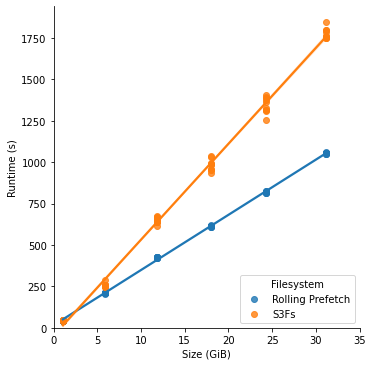

In [3]:
## Exp 1
import matplotlib.pyplot as plt
fs = S3FileSystem()
fs.invalidate_cache()

files = glob.glob("../results/us-west-2-xlarge/exp-2/readnib_*f_lazy_10r*")

df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
df["file"] = df["file"].apply(lambda x: [f for f in ast.literal_eval(x) if f != header])
df["n_files"] = df["file"].apply(lambda x: len(x))

df["size"] = df["file"].apply(lambda x: sum(file_sizes[f] for f in x) / 1024**3 )
df["Filesystem"] = df["action"].apply(lambda x: "Rolling Prefetch" if "prefetch" in x else "S3Fs")

df = df.sort_values(by="Filesystem")

ax = sns.lmplot(x="size", y="runtime", hue="Filesystem", data=df, legend=None)
plt.xlim([0, 35])
plt.ylim(0)
plt.xlabel("Size (GiB)")
plt.ylabel("Runtime (s)")
plt.legend(loc="lower right", title="Filesystem")
plt.savefig("../../paper/figures/filesize.pdf", bbox_inches='tight')

df = df[["Filesystem", "size", "runtime"]].groupby(["Filesystem", "size"]).agg({"runtime": "mean"})
df_rp = df.loc["Rolling Prefetch"]
df_s = df.loc["S3Fs"]

df = pd.merge(df_rp, df_s, on="size", suffixes=["_rp", "_s3fs"])
df["avg speedup"] = df["runtime_s3fs"] / df["runtime_rp"]
df

,runtime_rp,runtime_s3fs,avg speedup
n_blocks,,,
3,249.012155,207.424811,0.832991
6,198.577691,180.994995,0.911457
12,185.136029,211.263153,1.141124
24,189.553193,227.636807,1.200913
47,198.260524,243.393307,1.227644
94,213.619376,261.883894,1.225937
187,225.341135,280.495000,1.244757
374,277.242680,312.682525,1.127830
748,355.037585,344.505946,0.970337


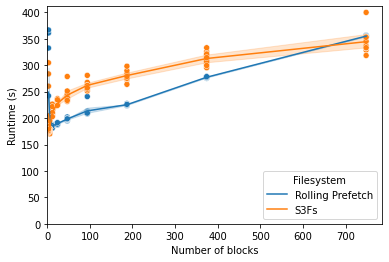

In [4]:
## Exp 2
import math

fs = S3FileSystem()
fs.invalidate_cache()
files = glob.glob("../results/us-west-2-xlarge/exp-1/readnib_5f_lazy_10r*")
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
df = df[~df["action"].str.contains("read_mem")]
df = df[df["blocksize"] != 1024]

df["file"] = df["file"].apply(lambda x: ast.literal_eval(x))
df["n_files"] = df["file"].apply(lambda x: len(x))

df["size"] = df["file"].apply(lambda x: sum(file_sizes[f] for f in x))
df["n_blocks"] = df["size"] / df["blocksize"]
df["n_blocks"] = df["n_blocks"].apply(lambda x: math.ceil(x))
df["Filesystem"] = df["action"].apply(lambda x: "Rolling Prefetch" if "prefetch" in x else "S3Fs")

df = df.sort_values(by="Filesystem")

ax = sns.scatterplot(x="n_blocks", y="runtime", hue="Filesystem", data=df, legend=None)
ax = sns.lineplot(x="n_blocks", y="runtime", hue="Filesystem", data=df)
ax.set_xlabel("Number of blocks")
ax.set_ylabel("Runtime (s)")
ax.legend(loc="lower right", title="Filesystem")

_ = ax.set_xlim(0)
_ = ax.set_ylim(0)

plt.savefig("../../paper/figures/blocksize.pdf")

df = df[["Filesystem", "n_blocks", "runtime"]].groupby(["Filesystem", "n_blocks"]).agg({"runtime": "mean"})
df_rp = df.loc["Rolling Prefetch"]
df_s = df.loc["S3Fs"]

df = pd.merge(df_rp, df_s, on="n_blocks", suffixes=["_rp", "_s3fs"])
df["avg speedup"] = df["runtime_s3fs"] / df["runtime_rp"]
df

Avg speedup:  1.5227769226801275


,,runtime_rp,runtime_s3fs,avg speedup
n_files,size,,,
1,2.914639,53.451210,80.672381,1.509271
5,24.241796,293.799454,546.064527,1.858630
10,51.925765,1252.322020,1833.563392,1.464131
15,80.644605,2266.303800,3115.433685,1.374676
20,108.481690,3033.351507,4268.459603,1.407176


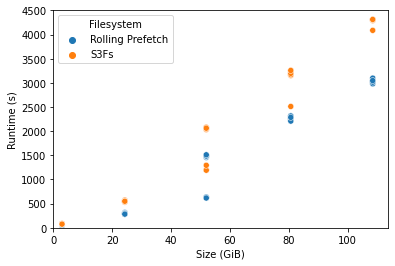

In [5]:
## Exp 3
from datetime import datetime

options = ['0-1', '1-2', '3-4', '4-5', '0-5', '0-10', '0-15', '0-20', '5-10', '10-20', '15-30', '20-40', '10-15', '20-30', '30-45', '40-60', '15-20', '30-40', '45-60', '60-80']
files = []

for opt in options:
    for rep in range(0, 10):
        files += glob.glob(f"../results/us-west-2-xlarge/exp-4/read_*_4parallel_{opt}_*{rep}.csv")

df = pd.concat((pd.read_csv(f).assign(rep=int(f.split("_")[-1].split(".")[0])) for f in files), ignore_index=True)

df["file"] = df["file"].apply(lambda x: [f for f in ast.literal_eval(x)if f != header])
df["n_files"] = df["file"].apply(lambda x: len(x))

df["size"] = df["file"].apply(lambda x: sum(file_sizes[f] for f in x) / 1024**3 )
df["Filesystem"] = df["action"].apply(lambda x: "Rolling Prefetch" if "prefetch" in x else "S3Fs")
df_delay = df[["timestamp", "Filesystem", "n_files", "rep"]].groupby(["Filesystem", "n_files", "rep"]).agg({"timestamp": "min"})

df = pd.merge(df, df_delay, on=["Filesystem", "n_files", "rep"])
df["start_delay"] = df["timestamp_x"] - df["timestamp_y"]
df["start_delay"] = df["start_delay"] * 10**-9
df["runtime"] += df["start_delay"]


df = df[["rep", "size", "n_files", "Filesystem", "runtime"]].groupby(["Filesystem", "n_files", "rep"]).agg({"runtime":"max", "size": "sum"})#.agg({'size':'sum', "runtime": "max"})
sns.scatterplot(x="size", y="runtime", hue="Filesystem", data=df)

plt.xlabel("Size (GiB)")
plt.ylabel("Runtime (s)")
plt.legend(loc="upper left", title="Filesystem")

plt.xlim(0)
plt.ylim([0, 4500])
plt.savefig("../../paper/figures/parallel.pdf")
df = df.groupby(["Filesystem", "n_files", "size"]).agg({"runtime": "mean"})
df_pf = df.loc["Rolling Prefetch"]
df_s = df.loc["S3Fs"]
df = pd.merge(df_pf, df_s, on=["n_files", "size"],suffixes=["_rp", "_s3fs"])
df["avg speedup"] = df["runtime_s3fs"] / df["runtime_rp"]
print("Avg speedup: ", df["avg speedup"].mean())
df